<h2 style="color:red">Description</h2>

The bank customer churn dataset is a commonly used dataset for predicting customer churn in the banking industry. It contains information on bank customers who either left the bank or continue to be a customer. The dataset includes the following attributes:

1. `id`: A unique identifier for a record
2. `CustomerId`: A unique identifier for each customer
3. `Surname`: The customer's surname or last name
4. `CreditScore`: A numerical value representing the customer's credit score
5. `Geography`: The country where the customer resides (France, Spain or Germany)
6. `Gender`: The customer's gender (Male or Female)
7. `Age`: The customer's age
8. `Tenure`: The number of years the customer has been with the bank
9. `Balance`: The customer's account balance
10. `NumOfProducts`: The number of bank products the customer uses (e.g., savings account, credit card)
11. `HasCrCard`: Whether the customer has a credit card (1=yes, 0=no)
12. `IsActiveMember`: Whether the customer is an active member (1=yes, 0=no)
13. `EstimatedSalary`: The estimated salary of the customer
14. `Exited`: Whether the customer has churned (1=yes, 0=no)

<h2 style="color:red">Task</h2>

Predict whether a customer continues with their account or closes it (e.g., churns).

<h2 style="color:red">Evaluation Metric</h2>

Submissions are evaluated on `area under the ROC curve` between the predicted probability and the observed target.

In [608]:
# import required libraries
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

# to suppress the warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [609]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e1/sample_submission.csv
/kaggle/input/playground-series-s4e1/train.csv
/kaggle/input/playground-series-s4e1/test.csv


In [610]:
# import the train & test dataset & create respective dataframes
churn_train_df = pd.read_csv("/kaggle/input/playground-series-s4e1/train.csv")
churn_test_df = pd.read_csv("/kaggle/input/playground-series-s4e1/test.csv")

In [611]:
# Top 5 records of train dataset
churn_train_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [612]:
# Top 5 records of test dataset
churn_test_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


In [613]:
# Shape of training dataset
churn_train_df.shape

(165034, 14)

In [614]:
# Shape of test dataset
churn_test_df.shape

(110023, 13)

In [615]:
# Training data info
churn_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [616]:
# Test data info
churn_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110023 entries, 0 to 110022
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               110023 non-null  int64  
 1   CustomerId       110023 non-null  int64  
 2   Surname          110023 non-null  object 
 3   CreditScore      110023 non-null  int64  
 4   Geography        110023 non-null  object 
 5   Gender           110023 non-null  object 
 6   Age              110023 non-null  float64
 7   Tenure           110023 non-null  int64  
 8   Balance          110023 non-null  float64
 9   NumOfProducts    110023 non-null  int64  
 10  HasCrCard        110023 non-null  float64
 11  IsActiveMember   110023 non-null  float64
 12  EstimatedSalary  110023 non-null  float64
dtypes: float64(5), int64(5), object(3)
memory usage: 10.9+ MB


<h2 style="color:red">Data Cleaning</h2>

<h3 style="color:red">1. Handle Missing Values</h3>

In [617]:
# Check missing values in train data
churn_train_df.isnull().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

<h4 style="color:red">We can see there are no missing values in the training data. Hence missing value treatment is not required.</h4>

In [618]:
# Check missing values in test data
churn_test_df.isnull().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

<h3 style="color:red">2. Handle Duplicate Values</h3>

In [619]:
# Check duplicate values in training data
churn_train_df[churn_train_df.duplicated()]

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


<h4 style="color:red">There are no duplicate values in the training dataset. Hence duplicate value treatment is not required.</h4>

In [620]:
# Check total number of duplicate values in test data
churn_test_df[churn_test_df.duplicated()]

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary


<h2 style="color:red">Data Exploration</h2>

In [621]:
# Check the count of unique values in target variable of training data
churn_train_df['Exited'].value_counts()

Exited
0    130113
1     34921
Name: count, dtype: int64

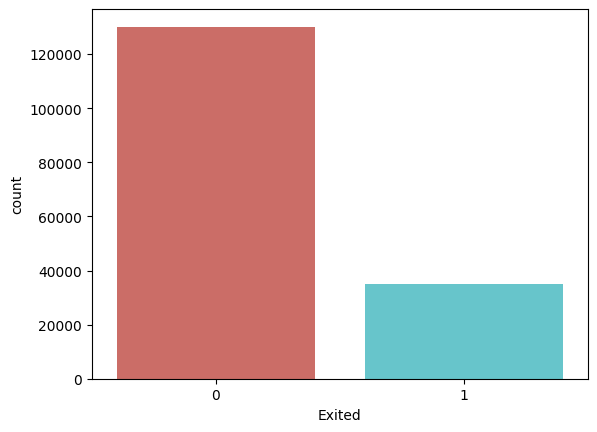

In [622]:
sns.countplot(x='Exited',data=churn_train_df,palette='hls')
plt.show()

In [623]:
# Calculate the percentage of churned & non-churned customers
count_non_churn = len(churn_train_df[churn_train_df['Exited']==0])
count_churn = len(churn_train_df[churn_train_df['Exited']==1])

print("Percentage of non-churn customers: ", (count_non_churn/(count_non_churn+count_churn))*100)
print("Percentage of churned customers: ", (count_churn/(count_non_churn+count_churn))*100)

Percentage of non-churn customers:  78.84011779390914
Percentage of churned customers:  21.159882206090867


<h4 style="color:red">The dataset is imbalanced. The ratio of non-churn to churn customers instances is 78:21.</h4>

In [624]:
numerical_features = churn_train_df.select_dtypes(include=["int64","float64"]).columns.tolist()

# Create a dataframe with only numerical features
numerical_churn_df = pd.DataFrame(churn_train_df, columns=numerical_features)

In [625]:
numerical_churn_df.head()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,668,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,627,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,678,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,581,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,716,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [626]:
# Group the average values of the features based on the churn & non-churn customers
numerical_churn_df.groupby('Exited').mean()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
Exited,,,,,,,,,,
0,82454.495416,1.569237e+07,657.590710,36.560480,5.048796,51255.807752,1.615273,0.758894,0.552228,112084.293725
1,82747.524384,1.569063e+07,652.220469,43.958478,4.914378,71209.978085,1.327854,0.735546,0.294866,114402.496656


<h4 style="color:red">Observations:</h4>

- The average credit score of churned customers is lower than that of the non-churn customers.
- The average age of churned customers is higher than that of the non-churn customers.
- The average tenure of churned customers is lower than that of the non-churn customers.
- The average account balance of the churned customers is higher than that of the non-churn customers.
- The average number of bank products the churned customers use is lower than that of the non-churn customers.
- The customers having credit card is lower in case of churned customers than that of the non-churn customers.
- On an average 30% of the churned customers & 55% of the non-churn customers are active members. That means inactive customers tend to churn more.
- The average estimated salary of the churned customers is more than that of the non-churn customers.

In [627]:
# List categorical features
categorical_features = churn_train_df.select_dtypes(include=['object']).columns.tolist()
categorical_features

['Surname', 'Geography', 'Gender']

In [628]:
# drop 'id','CustomerId','Surname','Gender' columns from the main dataframe & create another dataframe for further analysis
df1 = churn_train_df.drop(columns=['id','CustomerId','Surname','Gender'], axis=1)
df1.head()

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,France,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,627,France,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,678,France,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,581,France,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,716,Spain,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [629]:
# Group the average values of the features based on 'Geography'
df1.groupby('Geography').mean()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
Geography,,,,,,,,,
France,656.060638,37.615119,5.027554,37352.477370,1.584387,0.759868,0.505514,112483.924571,0.165282
Germany,656.920274,39.729209,4.978125,121235.738547,1.445010,0.749783,0.462405,113873.187463,0.378952
Spain,657.033524,37.922579,5.041974,39795.734545,1.581173,0.742551,0.511419,111570.563508,0.172176


<h4 style='color:red'>Observation:</h4>

- On an average, maximum number of customers churned are from Germany.
- The average credit score of the customers is highest in Spain  & lowest in France.
- The average age of customers in Germany is higher than France & Spain.
- The average customer account balance of Germany is much higher than France & Spain.
- The average estimated salary of customers of Germany is higher than France & Spain.
- The average number of customers who are active members, is lowest in Germany.

In [630]:
# drop 'id','CustomerId','Surname','Geography' columns from the main dataframe & create another dataframe for further analysis
df2 = churn_train_df.drop(columns=['id','CustomerId','Surname','Geography'], axis=1)
df2.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,627,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,678,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,581,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,716,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [631]:
# Group the average values of the features based on 'Gender'
df2.groupby('Gender').mean()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
Gender,,,,,,,,,
Female,656.243726,38.763207,4.992349,56529.169653,1.538200,0.750807,0.478577,113020.123777,0.279687
Male,656.616930,37.634068,5.041965,54666.964330,1.566999,0.756382,0.512582,112231.183226,0.159055


<h4 style='color:red'>Observations:</h4>

- The average credit score of male customers is more than that of female customers but with less difference.
- The average age of male customers is less than that of female customers.
- The average tenure of male customers is more than that of female customers.
- The average account balance of male customers is less than that of female customers.
- The average number of bank products used by male customers is more than that of female customers.
- On an average, male customers are more active members than that of female customers.
- The average estimated salary of male customers is less than that of female customers.
- Female customers churned more than male customers.

In [632]:
# drop 'id','CustomerId','Surname' columns from the main dataframe & create another dataframe for further analysis
df3 = churn_train_df.drop(columns=['id','CustomerId','Surname'], axis=1)
df3.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [633]:
# Group the average values of the features based on 'Geography' & 'Gender'
df3.groupby(['Geography','Gender']).mean()

CreditScore        Age    Tenure        Balance  \
Geography Gender                                                    
France    Female   655.929433  38.192591  4.999425   36719.956214   
          Male     656.157341  37.189503  5.048286   37818.667118   
Germany   Female   657.140774  40.497742  4.922199  121136.364515   
          Male     656.721923  39.037875  5.028433  121325.130447   
Spain     Female   656.106057  38.401439  5.048196   39332.675258   
          Male     657.729135  37.563427  5.037307   40143.034604   

                  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
Geography Gender                                                              
France    Female       1.570792   0.754703        0.488718    112752.813496   
          Male         1.594406   0.763676        0.517893    112285.744228   
Germany   Female       1.425494   0.749634        0.436905    114748.884800   
          Male         1.462564   0.749918        0.485344    113085.454015   
Spain     Female       1.573260   0.742010        0.496456    111883.207552   
          Male         1.587107   0.742957        0.522641    111336.076698   

                    Exited  
Geography Gender            
France    Female  0.225185  
          Male    0.121131  
Germany   Female  0.463510  
          Male    0.302887  
Spain     Female  0.225966  
          Male    0.131832

<h4 style='color:red'>Observations:</h4>

- In all the 3 countries, the female customers churned more than the male customers.
- In all the 3 countries, the average estimates salary of female customers is more than male customers.
- In all the 3 countries, male customers are more active members than that of female customers.
- In all the 3 countries, on an average, male customers have more credit card than that of female customers.
- In all the 3 countries, on an average, male customers use more number of bank products than that of female customers.
- In all the 3 countries, the average age of female customers is more than that of male customers. 

<h2 style='color:red'>Data Visualization</h2>

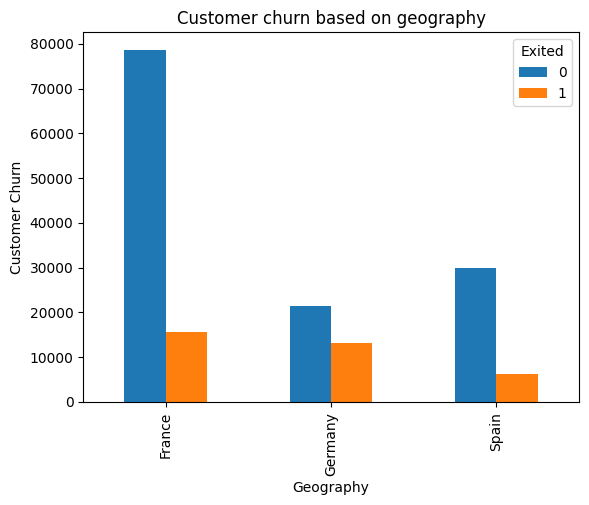

In [634]:
pd.crosstab(df3.Geography,df3.Exited).plot(kind='bar')
plt.title('Customer churn based on geography')
plt.xlabel('Geography')
plt.ylabel('Customer Churn')
plt.show()

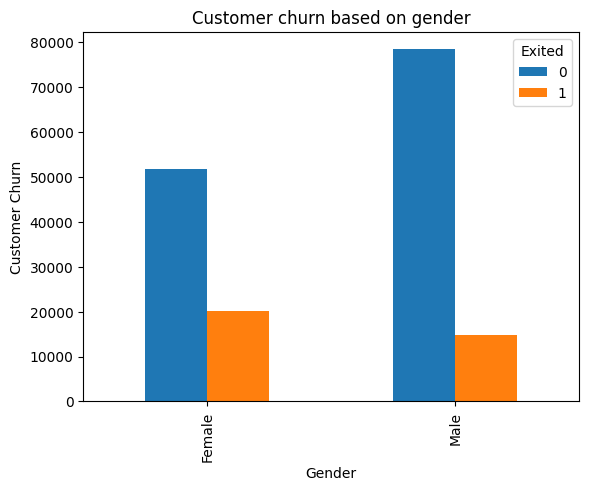

In [635]:
pd.crosstab(df3.Gender,df3.Exited).plot(kind='bar')
plt.title('Customer churn based on gender')
plt.xlabel('Gender')
plt.ylabel('Customer Churn')
plt.show()

<h4 style='color:red'>From the plot we can see that the male customers churn less than the female customers. Thus 'Gender' can be a good predictore of the churn.</h4>

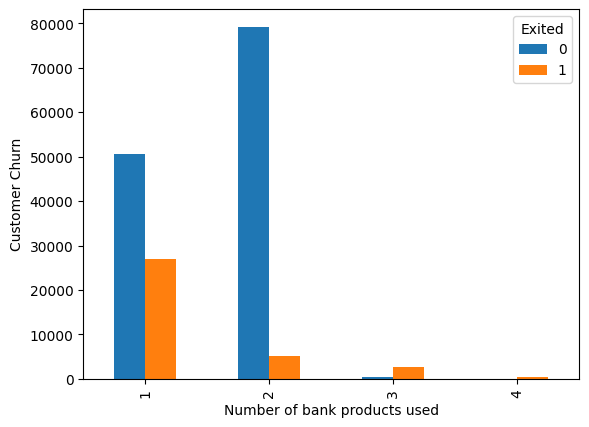

In [636]:
pd.crosstab(df3.NumOfProducts,df3.Exited).plot(kind='bar')
plt.xlabel('Number of bank products used')
plt.ylabel('Customer Churn')
plt.show()

<h4 style='color:red'>From the plot we can see that the customers who are using around 2 bank products, they are less likely to churn. The customers who are using more than 2 products, are more likely to churn. Thus 'NumOfProducts' can be a good predictore of the churn.</h4>

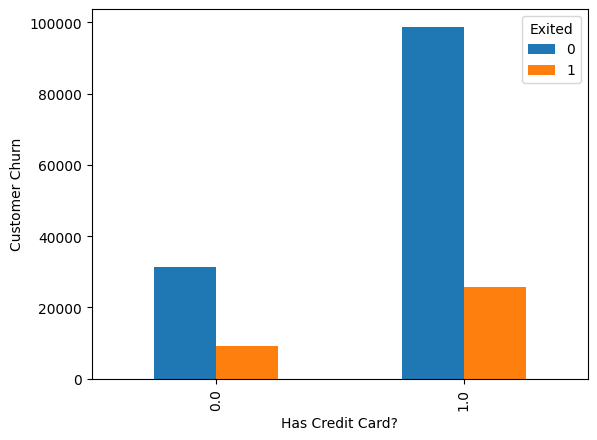

In [637]:
pd.crosstab(df3.HasCrCard,df3.Exited).plot(kind='bar')
plt.xlabel('Has Credit Card?')
plt.ylabel('Customer Churn')
plt.show()

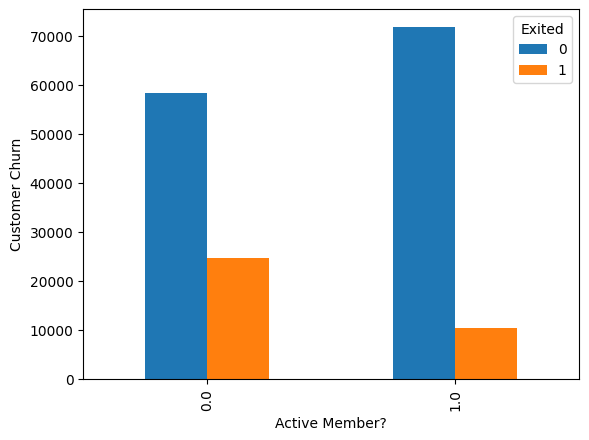

In [638]:
pd.crosstab(df3.IsActiveMember,df3.Exited).plot(kind='bar')
plt.xlabel('Active Member?')
plt.ylabel('Customer Churn')
plt.show()

<h4 style='color:red'>From the plot we can see that the customers who are active, the churn rate is less among those customers than the inactive customers. Thus 'IsActiveMember' can be a good predictore of the churn.</h4>

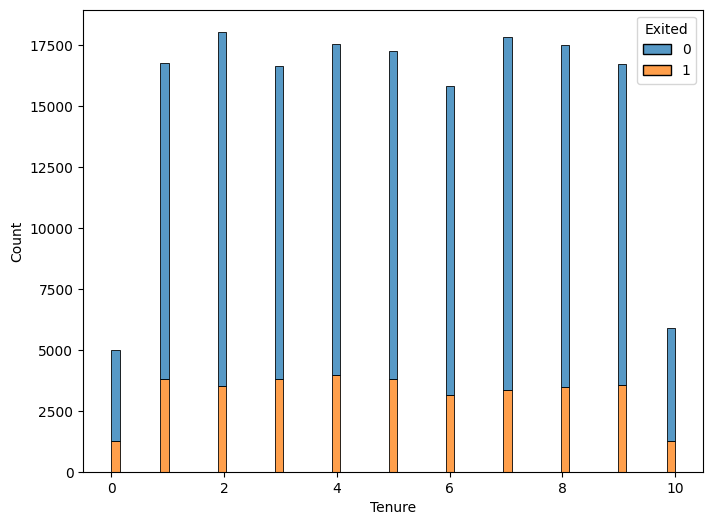

In [639]:
plt.figure(figsize=(8,6))
sns.histplot(df3,x='Tenure',hue='Exited', multiple='stack')
plt.show()

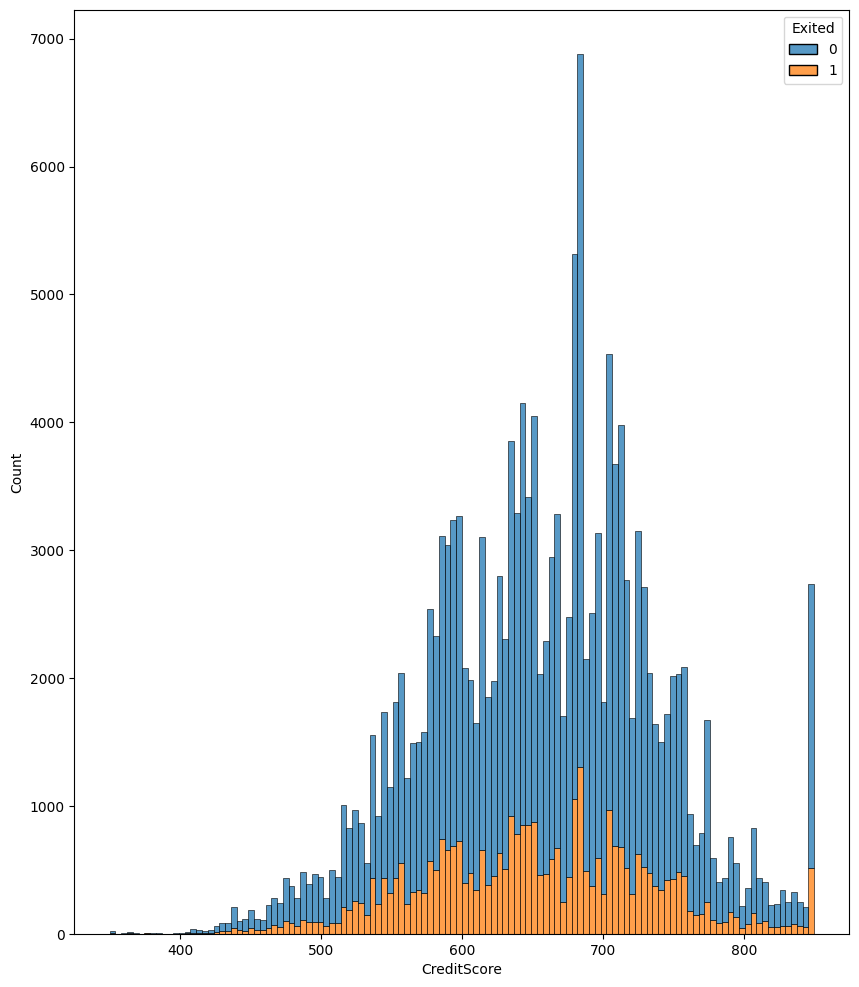

In [640]:
plt.figure(figsize=(10,12))
sns.histplot(df3,x='CreditScore',hue='Exited', multiple='stack')
plt.show()

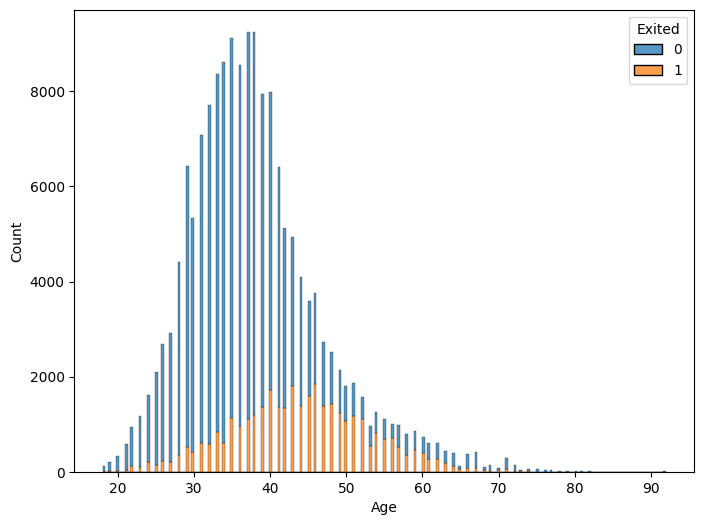

In [641]:
plt.figure(figsize=(8,6))
sns.histplot(df3,x='Age',hue='Exited', multiple='stack')
plt.show()

<h4 style='color:red'>From the plot we can see that as the age of customers passing 45, the churn rate is basically increasing. Thus 'Age' can be a good predictore of the churn.</h4>

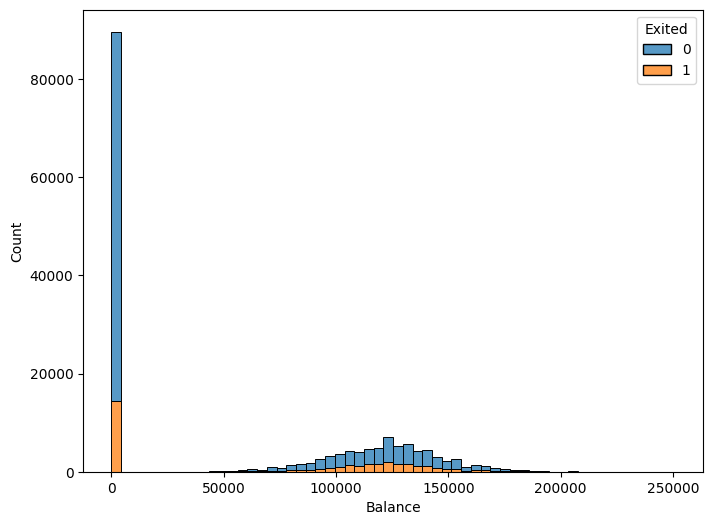

In [642]:
plt.figure(figsize=(8,6))
sns.histplot(df3,x='Balance',hue='Exited', multiple='stack')
plt.show()

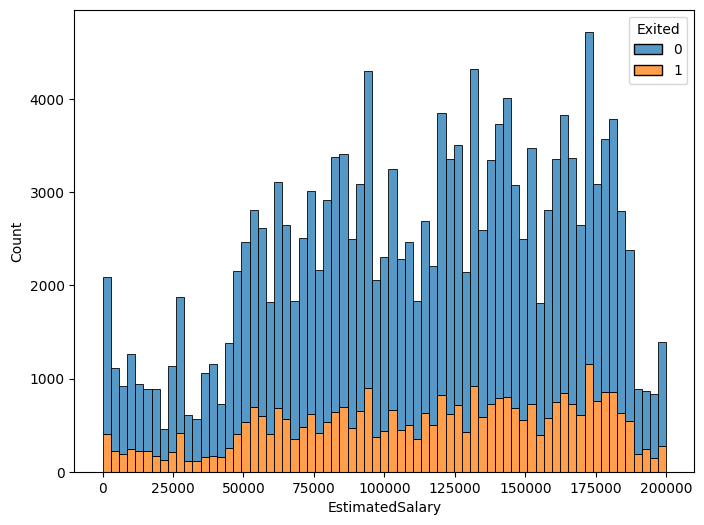

In [643]:
plt.figure(figsize=(8,6))
sns.histplot(df3,x='EstimatedSalary',hue='Exited', multiple='stack')
plt.show()

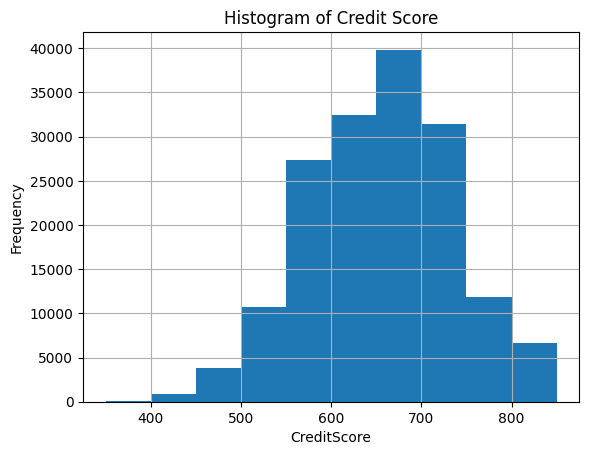

In [644]:
df3.CreditScore.hist()
plt.title('Histogram of Credit Score')
plt.xlabel('CreditScore')
plt.ylabel('Frequency')
plt.show()

<h4 style='color:red'>Most of the customers of the bank in the dataset have credit score in the range of 650-700.</h4>

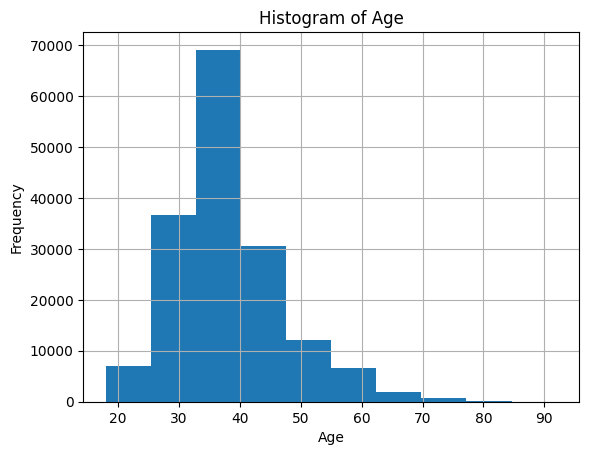

In [645]:
df3.Age.hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

<h4 style='color:red'>Most of the customers of the bank in this dataset are in the age range of 32.5-40.</h4>

<h3 style="color:red">Drop features not much helpful for model prediction</h3>

In [646]:
# Separate features and labels of training data
X = churn_train_df.drop("Exited", axis=1)
y = churn_train_df["Exited"]

In [647]:
# define a function to drop a list of columns from the train dataframe
def drop_column(df, col_list):
    for col in col_list:
        df.drop(col, axis=1, inplace=True)
        print(f"{col} has been dropped from the dataframe")

In [648]:
# List columns to be dropped
cols = ['id','CustomerId','Surname']

In [649]:
# Calling drop_column()
drop_column(X, cols)

id has been dropped from the dataframe
CustomerId has been dropped from the dataframe
Surname has been dropped from the dataframe


<h2 style='color:red'>Split data into train & validation set</h2>

In [650]:
# Split the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [651]:
# drop 'id','CustomerId','Surname' columns from test data & create X_test
X_test = churn_test_df.drop(['id','CustomerId','Surname'], axis=1)

In [652]:
# keeping values of id column of test dataset for later use (for file submission)
id_test = churn_test_df['id']

<h2 style="color:red">Data Preprocessing</h2>

<h3 style="color:blue">Encode Categorical Variables into numerical format</h3>

In [653]:
# List the categorical features using the data frame 'X'
cat_features = X.select_dtypes(include=['object']).columns.tolist()
cat_features

['Geography', 'Gender']

In [654]:
# define a function to perform one-hot-encoding & label-encoding simultaneously on categorical features
def encode_categorical(df, feature_name):
    df_encoded= pd.get_dummies(df, columns=[feature_name], prefix="Encoded_"+feature_name[0:3])
    print(f"Encoded dataframe for {feature_name} has been created.")
    
    # list encoded columns
    encoded_cols= df_encoded.filter(like='Encoded_').columns.tolist()
    print(f"Encoded columns are: {encoded_cols}")
    
    '''One-hot-encoding creates individual features based on values of the original categorical feature. 
    But the values of those encoded features used to be in boolean form.
    Hence creating another function to perform Label Encoding on those True & False values.'''
    def label_encode(df_encd, column):
        df_encd[column]=df_encd[column].astype(int)
        print(f"The Label Encoding done successfully for {column}.")
            
        return df_encd[column]
    
    for col in encoded_cols:
        df_encoded[col] = label_encode(df_encoded, col)
            
    return df_encoded

In [655]:
# Call 'encode_categorical' function to encode "Geography" & 'Gender' features of training dataframe
X_train_encoded = encode_categorical(X_train, 'Geography')
X_train_encoded = encode_categorical(X_train_encoded, 'Gender')
X_train_encoded.head()

Encoded dataframe for Geography has been created.
Encoded columns are: ['Encoded_Geo_France', 'Encoded_Geo_Germany', 'Encoded_Geo_Spain']
The Label Encoding done successfully for Encoded_Geo_France.
The Label Encoding done successfully for Encoded_Geo_Germany.
The Label Encoding done successfully for Encoded_Geo_Spain.
Encoded dataframe for Gender has been created.
Encoded columns are: ['Encoded_Geo_France', 'Encoded_Geo_Germany', 'Encoded_Geo_Spain', 'Encoded_Gen_Female', 'Encoded_Gen_Male']
The Label Encoding done successfully for Encoded_Geo_France.
The Label Encoding done successfully for Encoded_Geo_Germany.
The Label Encoding done successfully for Encoded_Geo_Spain.
The Label Encoding done successfully for Encoded_Gen_Female.
The Label Encoding done successfully for Encoded_Gen_Male.


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Encoded_Geo_France,Encoded_Geo_Germany,Encoded_Geo_Spain,Encoded_Gen_Female,Encoded_Gen_Male
149380,679,41.0,9,0.00,2,1.0,1.0,103560.98,1,0,0,0,1
164766,721,46.0,9,115764.32,2,1.0,0.0,102950.79,1,0,0,0,1
155569,551,35.0,5,0.00,1,1.0,0.0,155394.52,1,0,0,0,1
124304,743,31.0,3,57866.03,2,1.0,1.0,107428.42,0,0,1,1,0
108008,675,28.0,2,0.00,2,1.0,0.0,134110.93,1,0,0,0,1


In [656]:
# Call 'encode_categorical' function to encode "Geography" & 'Gender' features of validation dataframe
X_val_encoded = encode_categorical(X_val, 'Geography')
X_val_encoded = encode_categorical(X_val_encoded, 'Gender')
X_val_encoded.head()

Encoded dataframe for Geography has been created.
Encoded columns are: ['Encoded_Geo_France', 'Encoded_Geo_Germany', 'Encoded_Geo_Spain']
The Label Encoding done successfully for Encoded_Geo_France.
The Label Encoding done successfully for Encoded_Geo_Germany.
The Label Encoding done successfully for Encoded_Geo_Spain.
Encoded dataframe for Gender has been created.
Encoded columns are: ['Encoded_Geo_France', 'Encoded_Geo_Germany', 'Encoded_Geo_Spain', 'Encoded_Gen_Female', 'Encoded_Gen_Male']
The Label Encoding done successfully for Encoded_Geo_France.
The Label Encoding done successfully for Encoded_Geo_Germany.
The Label Encoding done successfully for Encoded_Geo_Spain.
The Label Encoding done successfully for Encoded_Gen_Female.
The Label Encoding done successfully for Encoded_Gen_Male.


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Encoded_Geo_France,Encoded_Geo_Germany,Encoded_Geo_Spain,Encoded_Gen_Female,Encoded_Gen_Male
33042,798,31.0,8,102075.88,1,1.0,0.0,79577.48,1,0,0,1,0
36330,629,26.0,6,0.00,2,1.0,0.0,38190.78,1,0,0,0,1
59446,565,39.0,7,115163.32,3,1.0,0.0,69052.63,1,0,0,0,1
92278,653,55.0,2,70263.83,1,0.0,0.0,62347.71,0,0,1,0,1
146750,557,31.0,6,106596.29,1,1.0,0.0,91305.77,1,0,0,1,0


In [657]:
# Call 'encode_categorical' function to encode "Geography" & 'Gender' features of test dataframe
X_test_encoded = encode_categorical(X_test, 'Geography')
X_test_encoded = encode_categorical(X_test_encoded, 'Gender')
X_test_encoded.head()

Encoded dataframe for Geography has been created.
Encoded columns are: ['Encoded_Geo_France', 'Encoded_Geo_Germany', 'Encoded_Geo_Spain']
The Label Encoding done successfully for Encoded_Geo_France.
The Label Encoding done successfully for Encoded_Geo_Germany.
The Label Encoding done successfully for Encoded_Geo_Spain.
Encoded dataframe for Gender has been created.
Encoded columns are: ['Encoded_Geo_France', 'Encoded_Geo_Germany', 'Encoded_Geo_Spain', 'Encoded_Gen_Female', 'Encoded_Gen_Male']
The Label Encoding done successfully for Encoded_Geo_France.
The Label Encoding done successfully for Encoded_Geo_Germany.
The Label Encoding done successfully for Encoded_Geo_Spain.
The Label Encoding done successfully for Encoded_Gen_Female.
The Label Encoding done successfully for Encoded_Gen_Male.


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Encoded_Geo_France,Encoded_Geo_Germany,Encoded_Geo_Spain,Encoded_Gen_Female,Encoded_Gen_Male
0,586,23.0,2,0.00,2,0.0,1.0,160976.75,1,0,0,1,0
1,683,46.0,2,0.00,1,1.0,0.0,72549.27,1,0,0,1,0
2,656,34.0,7,0.00,2,1.0,0.0,138882.09,1,0,0,1,0
3,681,36.0,8,0.00,1,1.0,0.0,113931.57,1,0,0,0,1
4,752,38.0,10,121263.62,1,1.0,0.0,139431.00,0,1,0,0,1


<h3 style='color:blue'>Feature Scaling</h3>

In [658]:
# Use StandardScaler to scale numerical features

# Identify numerical features
num_features = ['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary']

# Standardize numerical features of 'X_train_encoded', 'X_val_encoded' & 'X_test_encoded'
scaler = StandardScaler()

X_train_encoded[num_features] = scaler.fit_transform(X_train_encoded[num_features])
X_val_encoded[num_features] = scaler.transform(X_val_encoded[num_features])
X_test_encoded[num_features] = scaler.transform(X_test_encoded[num_features])

In [659]:
X_train_encoded.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Encoded_Geo_France,Encoded_Geo_Germany,Encoded_Geo_Spain,Encoded_Gen_Female,Encoded_Gen_Male
149380,0.277553,0.324586,1.416490,-0.884656,0.814086,1.0,1.0,-0.181454,1,0,0,0,1
164766,0.802272,0.888299,1.416490,0.956961,0.814086,1.0,0.0,-0.193591,1,0,0,0,1
155569,-1.321590,-0.351869,-0.007770,-0.884656,-1.014014,1.0,0.0,0.849538,1,0,0,0,1
124304,1.077125,-0.802839,-0.719900,0.035896,0.814086,1.0,1.0,-0.104529,0,0,1,1,0
108008,0.227580,-1.141067,-1.075965,-0.884656,0.814086,1.0,0.0,0.426198,1,0,0,0,1


In [660]:
X_val_encoded.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Encoded_Geo_France,Encoded_Geo_Germany,Encoded_Geo_Spain,Encoded_Gen_Female,Encoded_Gen_Male
33042,1.764257,-0.802839,1.060425,0.739200,-1.014014,1.0,0.0,-0.658497,1,0,0,1,0
36330,-0.347112,-1.366552,0.348295,-0.884656,0.814086,1.0,0.0,-1.481697,1,0,0,0,1
59446,-1.146684,0.099101,0.704360,0.947400,2.642186,1.0,0.0,-0.867841,1,0,0,0,1
92278,-0.047273,1.902981,-1.075965,0.233124,-1.014014,0.0,0.0,-1.001205,0,0,1,0,1
146750,-1.246630,-0.802839,0.348295,0.811113,-1.014014,1.0,0.0,-0.425216,1,0,0,1,0


<h3 style='color:blue'>Handle data imbalance with SMOTE</h3>

In [661]:
# oversampling minority class in train data using Synthetic Minority Oversampling Technique (SMOTE)
smote_samp = SMOTE(sampling_strategy='minority',random_state=42)


In [662]:
columns = X_train_encoded.columns

# Fit the model to generate the data.
X_train_resampled,y_train_resampled = smote_samp.fit_resample(X_train_encoded, y_train)

In [663]:
type(X_train_resampled)

pandas.core.frame.DataFrame

In [664]:
X_train_resampled.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Encoded_Geo_France,Encoded_Geo_Germany,Encoded_Geo_Spain,Encoded_Gen_Female,Encoded_Gen_Male
0,0.277553,0.324586,1.416490,-0.884656,0.814086,1.0,1.0,-0.181454,1,0,0,0,1
1,0.802272,0.888299,1.416490,0.956961,0.814086,1.0,0.0,-0.193591,1,0,0,0,1
2,-1.321590,-0.351869,-0.007770,-0.884656,-1.014014,1.0,0.0,0.849538,1,0,0,0,1
3,1.077125,-0.802839,-0.719900,0.035896,0.814086,1.0,1.0,-0.104529,0,0,1,1,0
4,0.227580,-1.141067,-1.075965,-0.884656,0.814086,1.0,0.0,0.426198,1,0,0,0,1


In [665]:
type(y_train_resampled)

pandas.core.series.Series

In [666]:
y_train_resampled_df = pd.DataFrame(y_train_resampled,columns=['Exited'])

# Oversampled dataframe
# oversampled_df = pd.concat([X_train_resampled_df, y_train_resampled_df], axis=1)

In [667]:
print("length of oversampled data is ",len(X_train_resampled))
print("Number of non churn records in oversampled data",len(y_train_resampled_df[y_train_resampled_df['Exited']==0]))
print("Number of churn records in oversampled data",len(y_train_resampled_df[y_train_resampled_df['Exited']==1]))
print("Proportion of non churn records in oversampled data is ",len(y_train_resampled_df[y_train_resampled_df['Exited']==0])/len(X_train_resampled))
print("Proportion of churn records in oversampled data is ",len(y_train_resampled_df[y_train_resampled_df['Exited']==1])/len(X_train_resampled))

length of oversampled data is  208122
Number of non churn records in oversampled data 104061
Number of churn records in oversampled data 104061
Proportion of non churn records in oversampled data is  0.5
Proportion of churn records in oversampled data is  0.5


<h4 style='color:red'>Now we have a perfect balanced data.</h4>

<h3 style='color:blue'>Data Distribution Check through Data Visualization</h3>

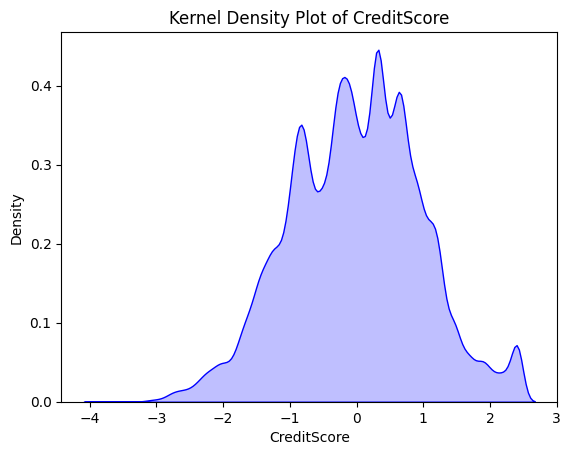

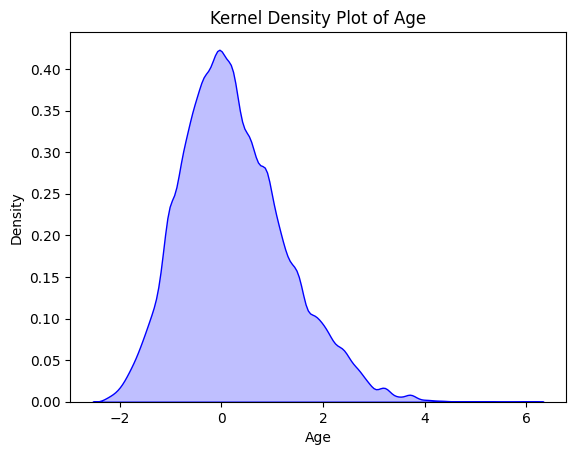

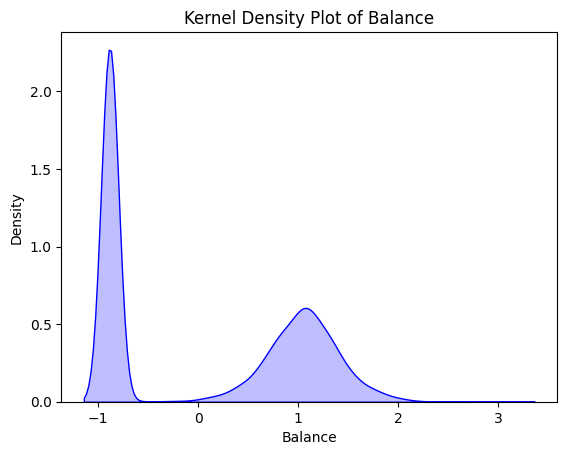

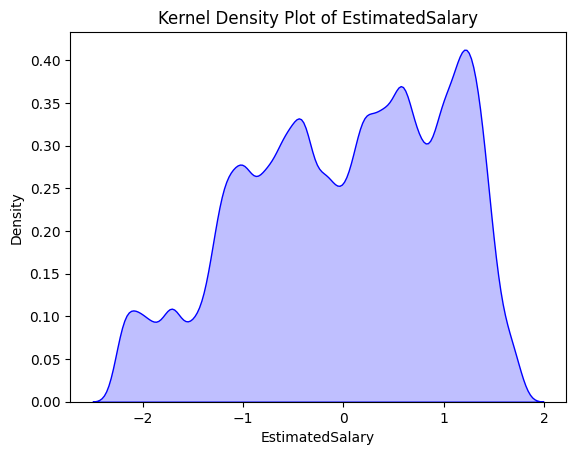

In [668]:
# list of selected numerical features
cols=['CreditScore','Age','Balance','EstimatedSalary']

# define a function to plot kernel density plot of all the selected features
def kdeplot_features(df, list_cols):
    for col in list_cols:
        sns.kdeplot(df[col],shade=True,color='blue')
        plt.title(f'Kernel Density Plot of {col}')
        plt.xlabel(f'{col}')
        plt.ylabel('Density')
        plt.show()

# Calling kdeplot_features()
kdeplot_features(X_train_resampled,cols)

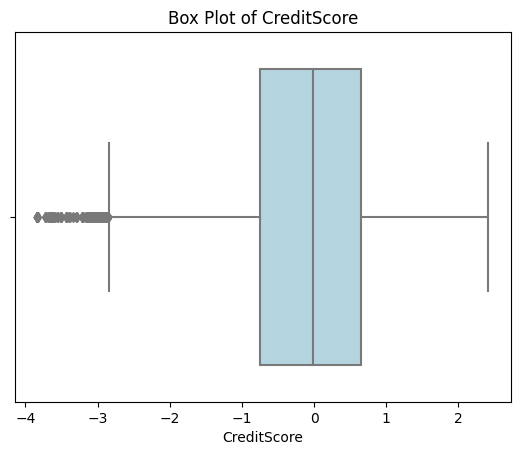

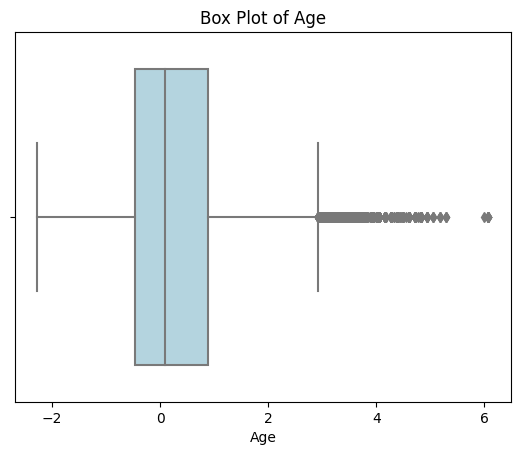

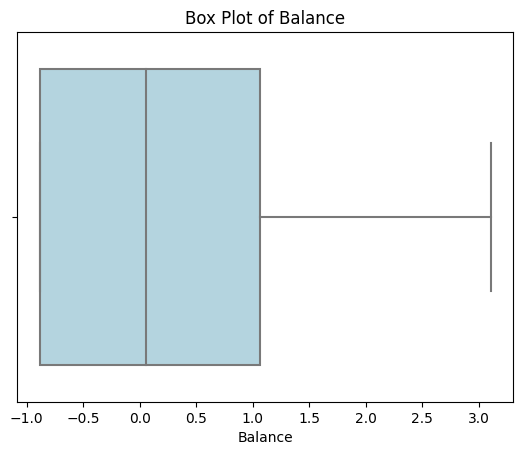

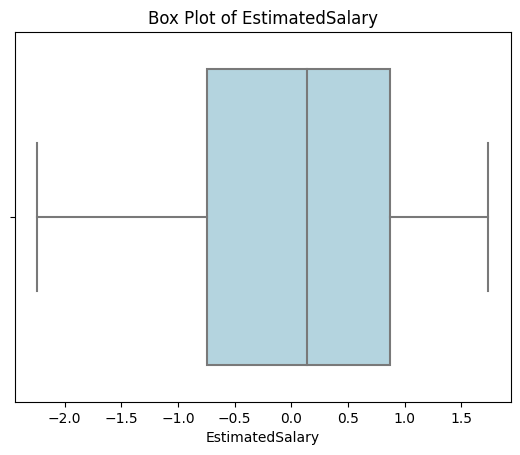

In [669]:
# define a function to plot box whisker plot of all the selected features
def boxplot_features(df, list_cols):
    for col in list_cols:
        sns.boxplot(x=df[col],color='lightblue')
        plt.title(f'Box Plot of {col}')
        plt.xlabel(f'{col}')
        plt.show()

# Calling kdeplot_features()
boxplot_features(X_train_resampled,cols)

<h2 style='color:red'>Feature Selection using Recursive Feature Elimination (RFE)</h2>

In [670]:
final_features = X_train_resampled.columns.values.tolist()

y = ['Exited']
X = [i for i in final_features if i not in y]

print(X)
print(y)

['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Encoded_Geo_France', 'Encoded_Geo_Germany', 'Encoded_Geo_Spain', 'Encoded_Gen_Female', 'Encoded_Gen_Male']
['Exited']


In [671]:
# Create LogisticRegression model instance
estimator = LogisticRegression(random_state=42)

In [672]:
# create RFE instance
selector = RFE(estimator,n_features_to_select=10,step=1)

In [673]:
# fit the RFE instance with the oversampled data
rfe = selector.fit(X_train_resampled, y_train_resampled_df)

In [674]:
print("The mask of selected features:\n",rfe.support_)

The mask of selected features:
 [False  True False  True  True  True  True False  True  True  True  True
  True]


- The RFE has helped us to select the following features: 'Age','Balance','NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Encoded_Geo_France', 'Encoded_Geo_Germany', 'Encoded_Geo_Spain', 'Encoded_Gen_Female', 'Encoded_Gen_Male'.

In [675]:
print("Feature ranking:\n", rfe.ranking_)

Feature ranking:
 [2 1 3 1 1 1 1 4 1 1 1 1 1]


In [676]:
selected_features=rfe.transform(X_train_resampled)
print("Shape:",selected_features.shape)

Shape: (208122, 10)


In [677]:
rfe_cols = ['Age','Balance','NumOfProducts','HasCrCard','IsActiveMember','Encoded_Geo_France',
            'Encoded_Geo_Germany','Encoded_Geo_Spain', 'Encoded_Gen_Female', 'Encoded_Gen_Male']

In [678]:
X_Train = X_train_resampled[rfe_cols]
y_Train = y_train_resampled

In [679]:
# list columns to drop as per RFE output 
cols_to_be_dropped = ['CreditScore','Tenure','EstimatedSalary']

# Calling drop_column()
drop_column(X_val_encoded, cols_to_be_dropped)
drop_column(X_test_encoded,cols_to_be_dropped)

CreditScore has been dropped from the dataframe
Tenure has been dropped from the dataframe
EstimatedSalary has been dropped from the dataframe
CreditScore has been dropped from the dataframe
Tenure has been dropped from the dataframe
EstimatedSalary has been dropped from the dataframe


<h2 style='color:red'>Implementing the model</h2>

In [680]:
# instantiate statsmodel
logit_model = sm.Logit(y_Train,X_Train)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.520267
         Iterations 6
                           Results: Logit
Model:               Logit             Method:            MLE        
Dependent Variable:  Exited            Pseudo R-squared:  0.249      
Date:                2024-01-25 17:41  AIC:               216578.1420
No. Observations:    208122            BIC:               216680.6008
Df Model:            9                 Log-Likelihood:    -1.0828e+05
Df Residuals:        208112            LL-Null:           -1.4426e+05
Converged:           1.0000            LLR p-value:       0.0000     
No. Iterations:      6.0000            Scale:             1.0000     
---------------------------------------------------------------------
                     Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
Age                  0.9057   0.0059  154.4269 0.0000  0.8942  0.9172
Balance         

- The p-value of all the variables are smaller than 0.05. Hence we will not remove any variable. 

In [681]:
# Fit the logistic regression model
estimator.fit(X_Train,y_Train)

LogisticRegression(random_state=42)

<h2 style='color:red'>Evaluate the base model</h2>

In [682]:
# predict on validation dataset
y_val_pred = estimator.predict(X_val_encoded)
y_val_pred_proba = estimator.predict_proba(X_val_encoded)[:,1]

In [683]:
print('Accuracy of logistic regression classifier on validation set: {:.2f}'.format(estimator.score(X_val_encoded, y_val)))

Accuracy of logistic regression classifier on validation set: 0.76


In [684]:
# Confusion Metrix
conf_matrix = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[19801  6251]
 [ 1808  5147]]


The result is telling us that we have 19801+5147=24948 correct predictions and 1808+6251=8059 incorrect predictions.

In [685]:
# Precision, recall, F-measure, support - Classification Report
class_report = classification_report(y_val, y_val_pred)
print("Classification Report:\n",class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.76      0.83     26052
           1       0.45      0.74      0.56      6955

    accuracy                           0.76     33007
   macro avg       0.68      0.75      0.70     33007
weighted avg       0.82      0.76      0.77     33007



In [686]:
# ROC AUC Score
roc_auc = roc_auc_score(y_val, y_val_pred_proba)
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.8185629625557821


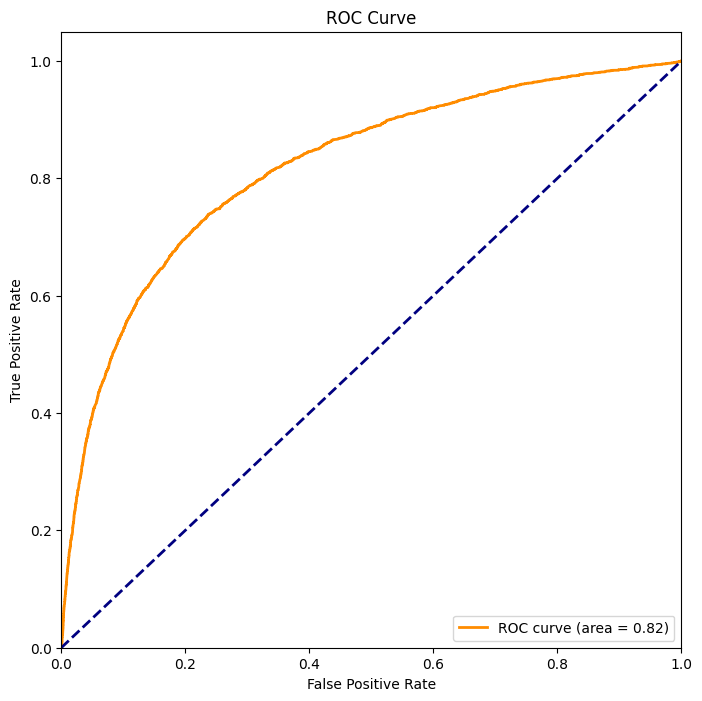

In [687]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

<h2 style='color:red'>Hyperparameter Tuning</h2>

In [688]:
# Hyperparameter tuning using GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(estimator, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_Train,y_Train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='roc_auc')

In [689]:
# Best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'C': 100}


In [690]:
# Fit the model with the best hyperparameters
final_logreg_model = LogisticRegression(C=best_params['C'], random_state=42)
final_logreg_model.fit(X_Train,y_Train)

LogisticRegression(C=100, random_state=42)

<h2 style='color:red'>Evaluate the best-parameter model</h2>

In [691]:
# predict on validation dataset
y_val_pred_new = final_logreg_model.predict(X_val_encoded)
y_val_pred_new_proba = final_logreg_model.predict_proba(X_val_encoded)[:,1]

In [692]:
print('Accuracy of logistic regression classifier on validation set: {:.2f}'.format(final_logreg_model.score(X_val_encoded, y_val)))

Accuracy of logistic regression classifier on validation set: 0.76


In [693]:
# Confusion Metrix
conf_matrix_new = confusion_matrix(y_val, y_val_pred_new)
print("Confusion Matrix:\n",conf_matrix_new)

Confusion Matrix:
 [[19827  6225]
 [ 1813  5142]]


In [694]:
# Precision, recall, F-measure, support - Classification Report
class_report_new = classification_report(y_val, y_val_pred_new)
print("Classification Report:\n", class_report_new)

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.76      0.83     26052
           1       0.45      0.74      0.56      6955

    accuracy                           0.76     33007
   macro avg       0.68      0.75      0.70     33007
weighted avg       0.82      0.76      0.77     33007



In [695]:
# ROC AUC Score
roc_auc_new = roc_auc_score(y_val, y_val_pred_new_proba)
print("ROC AUC Score:", roc_auc_new)

ROC AUC Score: 0.8185629625557821


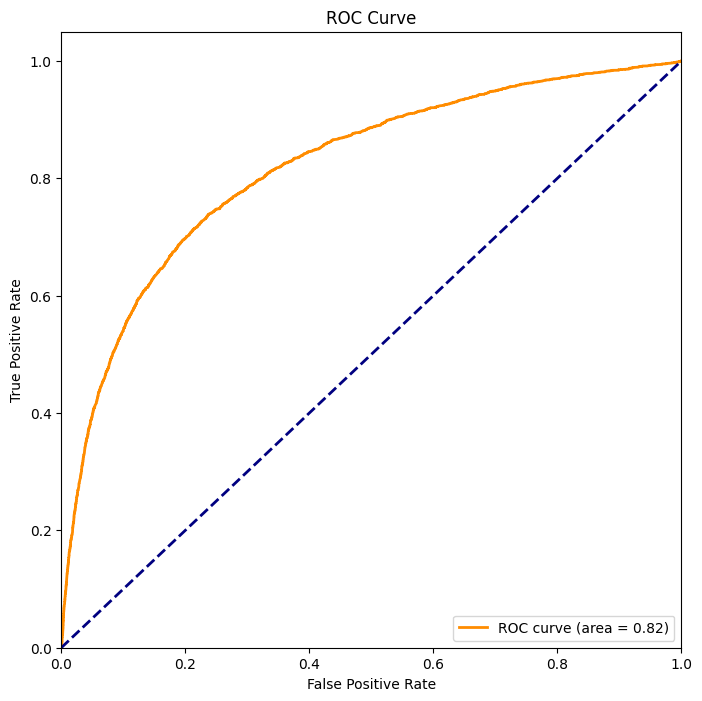

In [696]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_val_pred_new_proba)
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_new)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

<h4 style='color:red'>There is no change in the model performance after performing hyperparameter tuning. So, we will just consider this newly created model for prediction. There will not be any difference in prediction.</h4>

<h2 style='color:red'>Prediction on Test Data</h2>

In [697]:
# predict on test dataset
y_pred = final_logreg_model.predict(X_test_encoded)

In [698]:
# Combine Predictions with IDs for the expected output
output_df = pd.DataFrame({'id': id_test, 'Exited': y_pred})
output_df.head()

,id,Exited
0,165034,0
1,165035,1
2,165036,0
3,165037,0
4,165038,1


In [699]:
# Shape of output file
output_df.shape

(110023, 2)

In [700]:
# Save the predictions to a CSV file
output_df.to_csv('lr_predictions_2.csv', index=False)